# Diving Deeper into DataRobot Models

---

## Setup
<div class="alert alert-box alert-info">
<b>Important</b>: this workbook requires that you already have completed the <b>Basic Introduction to DataRobot via API</b> notebook in this series.
</div>

The [intro notebook](Basic Introduction to DataRobot via API.ipynb) should have saved some of the results from your prior work; we will attempt to load those values in now:

In [1]:
import json

with open('intro-notebook-output.json') as fp:
    params = json.load(fp)

# Validate
assert params.get('project-id')
assert params.get('best-model-id')

### Connecting to DataRobot
#### Endpoint

In [2]:
endpoint = 'https://app.datarobot.com/api/v2'

#### Token

In [3]:
token = 'YOUR_TOKEN_HERE'

assert token != 'YOUR_TOKEN_HERE'

#### Setting the configuration in code
The next cell will configure the datarobot package to use the provided endpoint and token. This only needs to be done once per session.

In [4]:
import datarobot as dr 
dr.Client(endpoint=endpoint, token=token)

The connection to DataRobot should now be ready.

---
## Getting and Evaluating Models

Previously, when you trained your DataRobot project, you got a project ID in the printed text. We will need that ID to further explore the models created.

In [5]:
project = dr.Project.get(params['project-id'])
project

Project(Airline Delay)

From a project, you can have DataRobot return a list of all the model objects it created as part of auto-modeling. The output of `get_models()` is sorted from best to worst based on the metric selected during project creation.

In [6]:
models = project.get_models()
len(models)

63

However, for the purposes of this notebook, lets just use the model that was selected from the _intro notebook_.

In [7]:
model = dr.Model.get(project.id, params['best-model-id'])
model

Model('ENET Blender')

We can get model metrics to see how the model performed.

In [8]:
import pandas as pd

pd.DataFrame(model.metrics)

,AUC,FVE Binomial,Gini Norm,Kolmogorov-Smirnov,LogLoss,RMSE,Rate@Top10%,Rate@Top5%,Rate@TopTenth%
backtesting,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
backtestingScores,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
crossValidation,0.766266,0.161266,0.532532,0.416432,0.268228,0.273496,0.396588,0.510206,0.866668
holdout,0.768030,0.153640,0.536060,0.425680,0.270590,0.275850,0.355190,0.469950,0.750000
validation,0.759070,0.155840,0.518140,0.397820,0.270090,0.274000,0.399320,0.503400,1.000000


For this project, the most useful metric is logarithmic loss, so let's look at that.

In [9]:
model.metrics['LogLoss']

{'backtesting': None,
 'backtestingScores': None,
 'crossValidation': 0.268228,
 'holdout': 0.27059,
 'validation': 0.27009}

## Feature Impact

Feature Impact measures how important a feature is in generating predictions by the model. That is, it measures how much the accuracy of a model would decrease if that feature were removed.

Feature Impact is available for all model types. It is an on-demand feature, meaning that you must initiate a calculation to see the results. Once you have had DataRobot compute the feature impact for a model, that information is saved with the project. Let's give it a try:

In [10]:
try:
    feature_impacts = model.get_feature_impact()  # check if they've already been computed
except dr.errors.ClientError as e:
    assert e.status_code == 404  # it hasn't been computed yet
    impact_job = model.request_feature_impact()
    feature_impacts = impact_job.get_result_when_complete(4*60)  # wait a few minutes to complete

We can now create a visualization similar to what you would see in the DataRobot UI:

In [11]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [12]:
matplotlib.rcParams['figure.figsize'] = (15, 10)  # make charts bigger
plt.rcParams['axes.facecolor'] = '#08233F'  # DataRobot Dark Blue

Text(0.5,1.04,'Feature Impact')

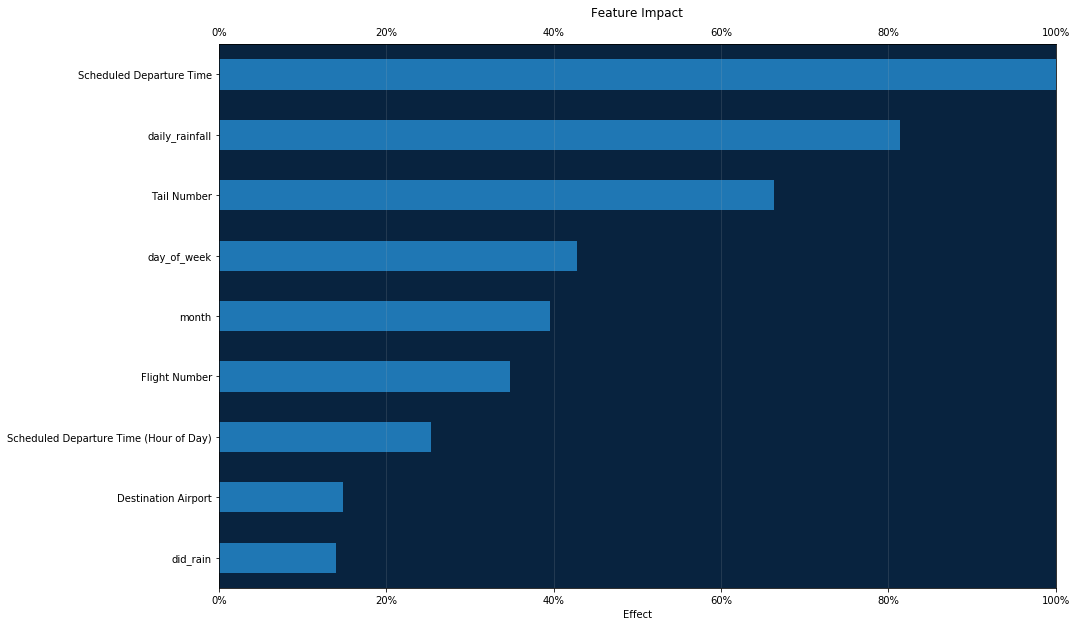

In [13]:
dr_blue = '#1F77B4'
dr_red = '#BE3C28'

# Formats the ticks from a float [0,1] into a percent, 40%
percent_tick_fmt = mtick.PercentFormatter(xmax=1.0)

impact_df = pd.DataFrame(feature_impacts)
impact_df.sort_values(by='impactNormalized', ascending=True, inplace=True)

# Positive values are blue, negative are red
bar_colors = impact_df.impactNormalized.apply(lambda x: dr_red if x < 0 else dr_blue)

ax = impact_df.plot.barh(x='featureName', y='impactNormalized', legend=False, color=dr_blue)
ax.xaxis.set_major_formatter(percent_tick_fmt)
ax.xaxis.set_tick_params(labeltop='on')
ax.xaxis.grid(True, alpha=0.2)

plt.ylabel('')
plt.xlabel('Effect')
plt.xlim((None,1))  # Allow for negative impact
plt.title('Feature Impact', y=1.04)

Here we can see that the `Scheduled Departure Time` is in-fact the most impactful feature to predicting if a flight will be delayed or not. The _Effect_ is normalized to the top feature so one feature will **always** have 100% and the other will be ranked relative to that.

## Lift Chart

Based on the evaluation metrics, we can plot a lift chart! A lift chart will show you how close in general model predictions are to the actual target values in the training data.

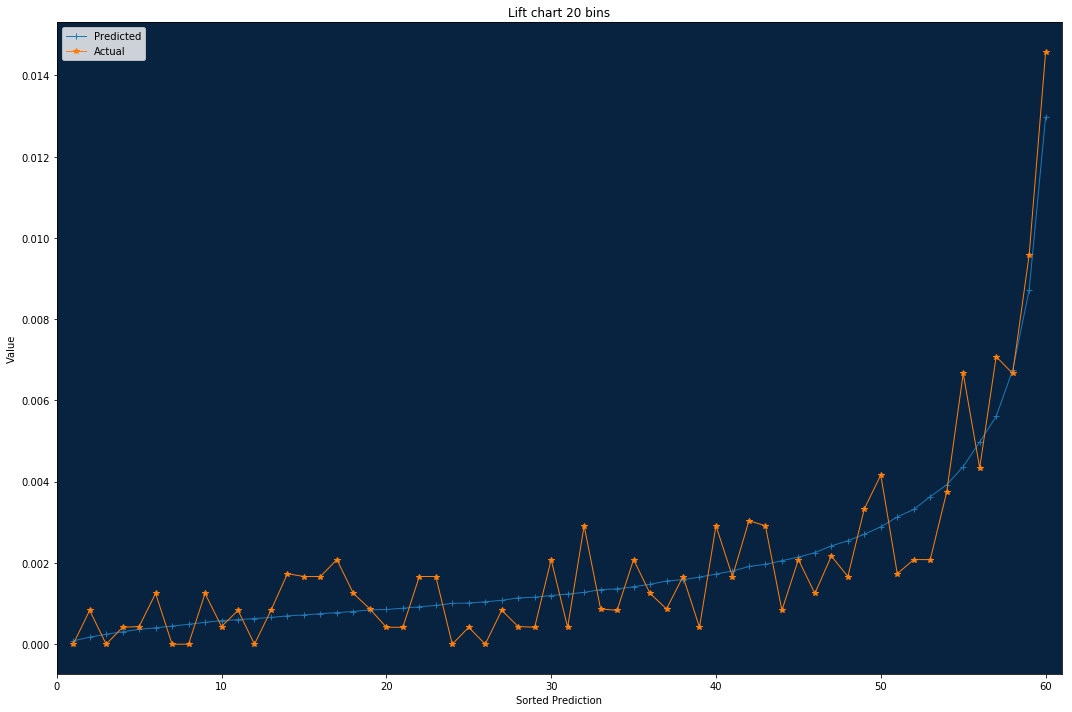

In [14]:
dr_orange = '#FF7F0E'

lift_chart = model.get_lift_chart(dr.enums.CHART_DATA_SOURCE.VALIDATION)
bins_df = pd.DataFrame(lift_chart.bins)

def matplotlib_lift(bins_df, bin_count, ax):
    grouped = bins_df.groupby(
        lambda row_index: row_index * bin_count / 60).sum()
    grouped['Actual'] = grouped['actual'] / grouped['bin_weight']
    grouped['Predicted'] = grouped['predicted'] / grouped['bin_weight']
    grouped.sort_values(by='Predicted', inplace=True)
    grouped.index = range(0, len(grouped))
    ax.plot(range(1, len(grouped) + 1), grouped['Predicted'],
            marker='+', lw=1, color=dr_blue)
    ax.plot(range(1, len(grouped) + 1), grouped['Actual'],
            marker='*', lw=1, color=dr_orange)
    ax.set_xlim([0, len(grouped) + 1])
    ax.set_title('Lift chart {} bins'.format(bin_count))
    ax.set_xlabel('Sorted Prediction')
    ax.set_ylabel('Value')


matplotlib_lift(bins_df, 20, plt.subplots()[1])
plt.tight_layout()
legend = plt.legend()
legend.get_frame().set_facecolor('white')

## ROC Curve

We also can plot the ROC curve. The receiver operating characteristic curve, or ROC curve, is a graphical plot that illustrates the performance of a binary classifier system as its discrimination threshold is varied. The curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings.

(0, 1)

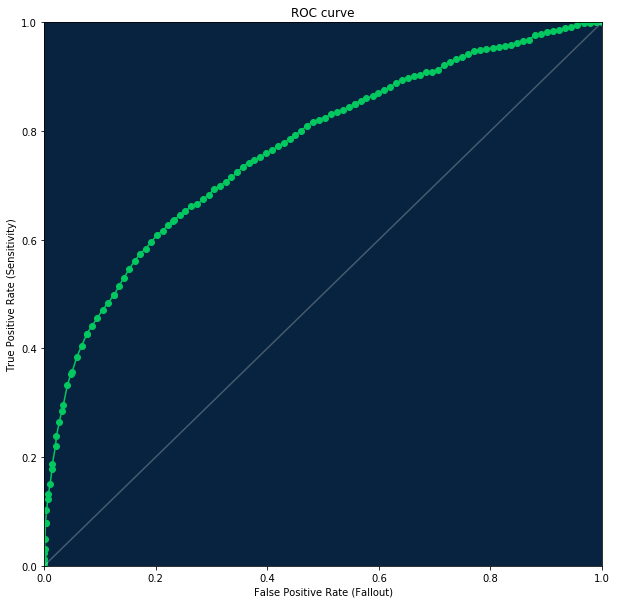

In [15]:
roc = model.get_roc_curve('crossValidation')
roc_df = pd.DataFrame(roc.roc_points)

dr_roc_green = '#03c75f'
white = '#ffffff'
dr_purple = '#65147D'
dr_dense_green = '#018f4f'

fig = plt.figure(figsize=(10, 10))  # it looks best when it is a square
axes = fig.add_subplot(1, 1, 1)

plt.scatter(roc_df.false_positive_rate, roc_df.true_positive_rate, color=dr_roc_green)
plt.plot(roc_df.false_positive_rate, roc_df.true_positive_rate, color=dr_roc_green)
plt.plot([0, 1], [0, 1], color=white, alpha=0.25)
plt.title('ROC curve')
plt.xlabel('False Positive Rate (Fallout)')
plt.xlim([0, 1])
plt.ylabel('True Positive Rate (Sensitivity)')
plt.ylim([0, 1])

This is a pretty reasonable looking ROC plot. Generally, the better a model, the larger the _area under the curve_ (AUC) will be so visually you are looking for a curve _stretching_ up and to the left as possible. The middle gray line represents flipping a coin essentially. As we can see, this model is certainly better than flipping a coin and maybe with more feature engineering, it could be improved more.

Lastly, we can use the ROC curve to create a prediction distribution plot.

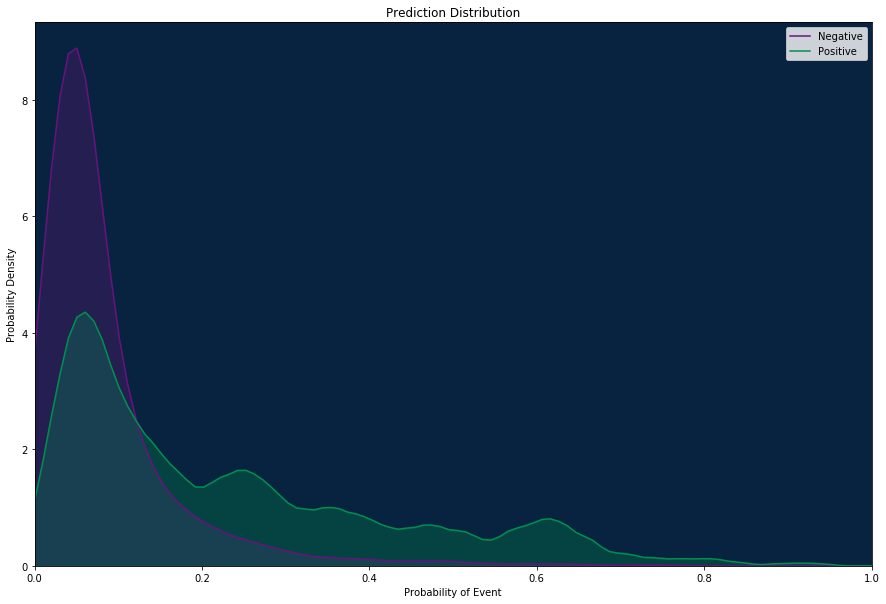

In [16]:
# It is possible to plot a more simplistic distribution with seaborn's kdeplot
# but using scikit-learn is the most accurate and will better reflect what
# you will see in the DataRobot UI.
from sklearn.neighbors import KernelDensity
import numpy as np

fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
xs = np.linspace(0, 1, 100)

X_neg = np.asarray(roc.negative_class_predictions)[:, np.newaxis]
density_neg = KernelDensity(bandwidth=0.05, kernel='epanechnikov').fit(X_neg)
plt.plot(xs, np.exp(density_neg.score_samples(xs[:, np.newaxis])),
         color=dr_purple,
         label='Negative')
plt.fill_between(xs, 0, np.exp(density_neg.score_samples(xs[:, np.newaxis])),
                 color=dr_purple, alpha=0.3)

X_pos = np.asarray(roc.positive_class_predictions)[:, np.newaxis]
density_pos = KernelDensity(bandwidth=0.05, kernel='epanechnikov').fit(X_pos)
plt.plot(xs, np.exp(density_pos.score_samples(xs[:, np.newaxis])),
         color=dr_dense_green,
         label='Positive')
plt.fill_between(xs, 0, np.exp(density_pos.score_samples(xs[:, np.newaxis])),
                 color=dr_dense_green, alpha=0.3)

plt.title('Prediction Distribution')
plt.xlabel('Probability of Event')
plt.xlim([0, 1])
plt.ylim([0, None])
plt.ylabel('Probability Density')
legend = plt.legend()
legend.get_frame().set_facecolor('white')

Here we can see our prediction distribution is heavily right-skewed. Since the training dataset predominantly contains examples of flights that **were not** delayed, this skew is not unusual.

---
## Conclusion
For more information consult our [official documentation](https://datarobot-public-api-client.readthedocs-hosted.com) or continue working through to our next notebook in this tutorial: [Working with Reason Codes](Working with DataRobot Reason Codes.ipynb).